In this notebook, we'll we solving a simple ODE using a pytorch NN

The differential equation we will be solving is:
$$
f' = R(1-t)*t
$$

In [1]:
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
class NNapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

PINN = NNapproximator(2,2)

In [3]:
PINN(torch.tensor([[1.0],[1.0]]))

tensor([[-0.0755],
        [-0.0755]], grad_fn=<AddmmBackward0>)

In [4]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [5]:
T0 = 0.0
F0 = 1.0 # Boundary condition
R = 1 # Parameter


def compute_loss(nn,x):
    de_loss = df(nn,x) - R*x*(1-x)
    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    bc_loss = f(nn,boundary) - F0
    final_loss = de_loss.pow(2).mean() + bc_loss**2
    return final_loss



In [6]:
def optimise(optimiser,nn,x):
    optimiser.zero_grad()
    loss = compute_loss(nn,x)
    loss.backward()
    optimiser.step()
    return loss

In [7]:
lr = 0.001
epochs = 30000
# Run the full thing
t_data = torch.linspace(0, 3, steps=10, requires_grad=True).view(-1, 1)
PINN = NNapproximator(2,10)


pi_optimizer = Adam(PINN.parameters(), lr=lr)

In [8]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    loss = optimise(pi_optimizer,PINN,t_data)
    if i % 1000==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy()[0])
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


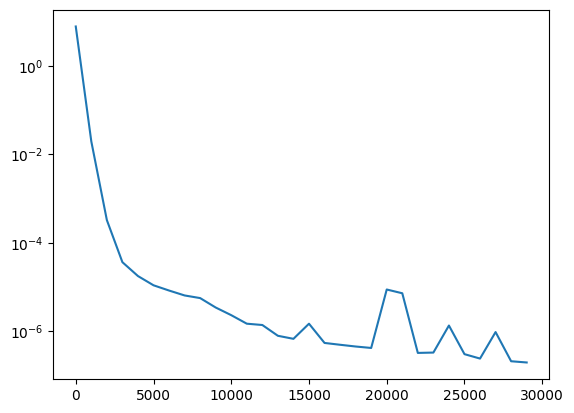

In [9]:
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

In [10]:
# Now let's compare the solution tot he actual answer

In [11]:
def f_true(t):
    return F0-t**3 / 3 + t**2/2

In [18]:
t_data_domain = torch.linspace(-2, 3.5, steps=1000).view(-1, 1)
t_data_domain_numpy = t_data_domain.detach().numpy()

In [19]:
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()

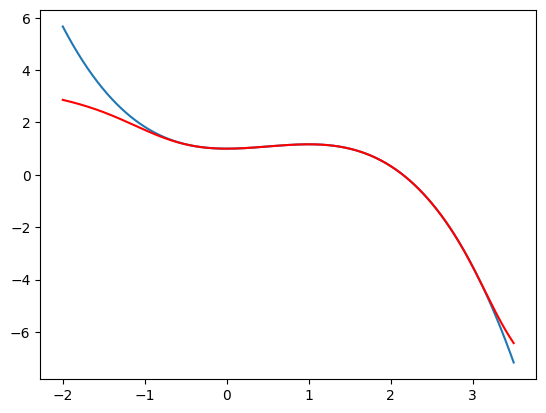

In [20]:
plt.plot(t_data_domain,f_true(t_data_domain))
plt.plot(t_data_domain,f_prediction,'r')